<a href="https://www.kaggle.com/code/iamommpatel/indian-weather-predictor?scriptVersionId=168886250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-forecasting-indias-weather/NM Weather Data in India from 1901 to 2017 - Weather Data in India from 1901 to 2017.csv


# Importing Essentials !!

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import plotly.express as pl
import plotly.io as pi
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

Loading Dataset


In [78]:
df = pd.read_csv("/kaggle/input/ml-olympiad-forecasting-indias-weather/NM Weather Data in India from 1901 to 2017 - Weather Data in India from 1901 to 2017.csv")

In [79]:
# Melt the data and parse the date using method chaining
melted_df = (
    df.melt(id_vars='YEAR', value_vars=df.columns[1:])
    .assign(Date=lambda x: pd.to_datetime(x['variable'] + ' ' + x['YEAR'].astype(str), format='%m %Y'))
    .rename(columns={'YEAR': 'Year', 'variable': 'Month', 'value': 'Temperature'})
    .sort_values(by='Date')
    .reset_index(drop=True)
)
melted_df

,Year,Month,Temperature,Date
0,1901,1,17.99,1901-01-01
1,1901,2,19.43,1901-02-01
2,1901,3,23.49,1901-03-01
3,1901,4,26.41,1901-04-01
4,1901,5,28.28,1901-05-01
...,...,...,...,...
1399,2017,8,28.12,2017-08-01
1400,2017,9,28.11,2017-09-01
1401,2017,10,27.24,2017-10-01
1402,2017,11,23.92,2017-11-01


In [26]:
melted_df.shape

(1404, 4)

In [27]:
melted_df.describe() #basic statistical analysis

,Year,Temperature,Date
count,1404.000000,1404.000000,1404
mean,1959.000000,24.294160,1959-06-16 20:02:03.076923072
min,1901.000000,17.250000,1901-01-01 00:00:00
25%,1930.000000,21.067500,1930-03-24 06:00:00
50%,1959.000000,25.570000,1959-06-16 00:00:00
75%,1988.000000,27.240000,1988-09-08 12:00:00
max,2017.000000,30.780000,2017-12-01 00:00:00
std,33.785791,3.516446,NaN


# Rapid Data Exploration using Pandas Profiling

In [7]:
pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.25.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have sh

In [8]:
import ydata_profiling as ypf

profile = ypf.ProfileReport(melted_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The above profiling concludes that we have got a very simple, clean and balanced dataset without any null values. 

# **Performing EDA !!**

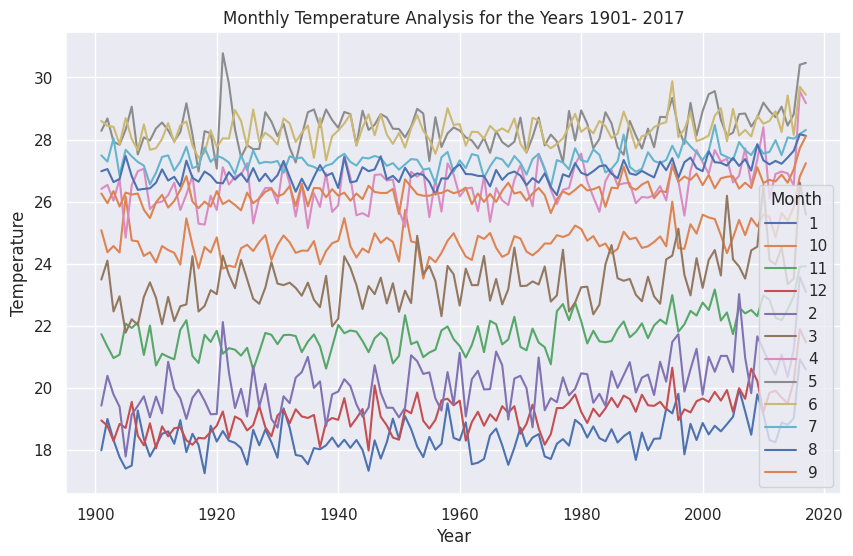

In [53]:
# Melt the month data (1,2,3...12) to single column month (column 1) and temperature (column 2) for each year
new_df = df.melt(id_vars=["ID","YEAR"], var_name="Month", value_name="Temperature")

# Reshape to get month as column names
df_reshape = df_melt.pivot_table(
    values="Temperature", index="YEAR", columns="Month"
)
# Plot line chart
df_reshape.plot(kind="line", figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Monthly Temperature Analysis for the Years 1901- 2017")
plt.legend(title="Month")
plt.show()


Identifying sudden spikes in monthly temperature variations, potentially indicative of outliers influenced by factors such as global warming or natural disasters

In [80]:
melted_df

,Year,Month,Temperature,Date
0,1901,1,17.99,1901-01-01
1,1901,2,19.43,1901-02-01
2,1901,3,23.49,1901-03-01
3,1901,4,26.41,1901-04-01
4,1901,5,28.28,1901-05-01
...,...,...,...,...
1399,2017,8,28.12,2017-08-01
1400,2017,9,28.11,2017-09-01
1401,2017,10,27.24,2017-10-01
1402,2017,11,23.92,2017-11-01


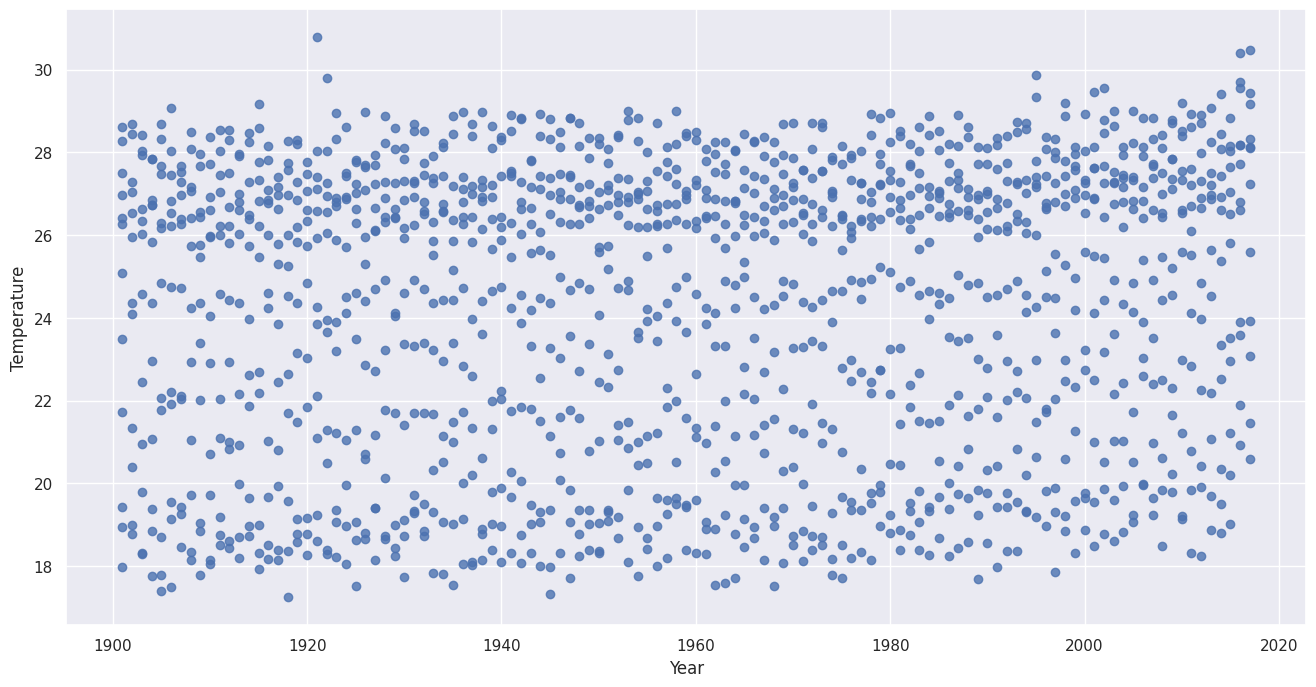

In [32]:
#Observing Increase in Temperature towards recent years.
sns.set()
plt.figure(figsize=(16,8))
sns.regplot(x = "Year",y="Temperature",fit_reg = False,data=melted_df)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

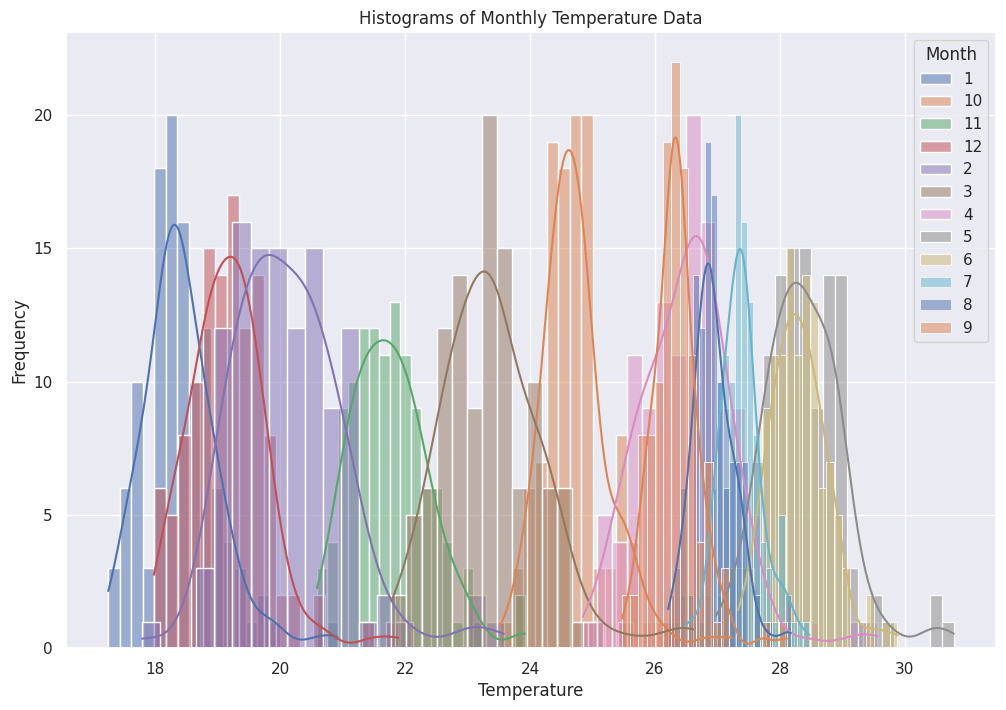

In [54]:
# Plot histograms for each month
plt.figure(figsize=(12, 8))
for column in df_reshape.columns:
    if column not in ['ID', 'YEAR']:
        sns.histplot(df_reshape[column], kde=True, label=column, bins=20)

plt.title('Histograms of Monthly Temperature Data')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(title='Month')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


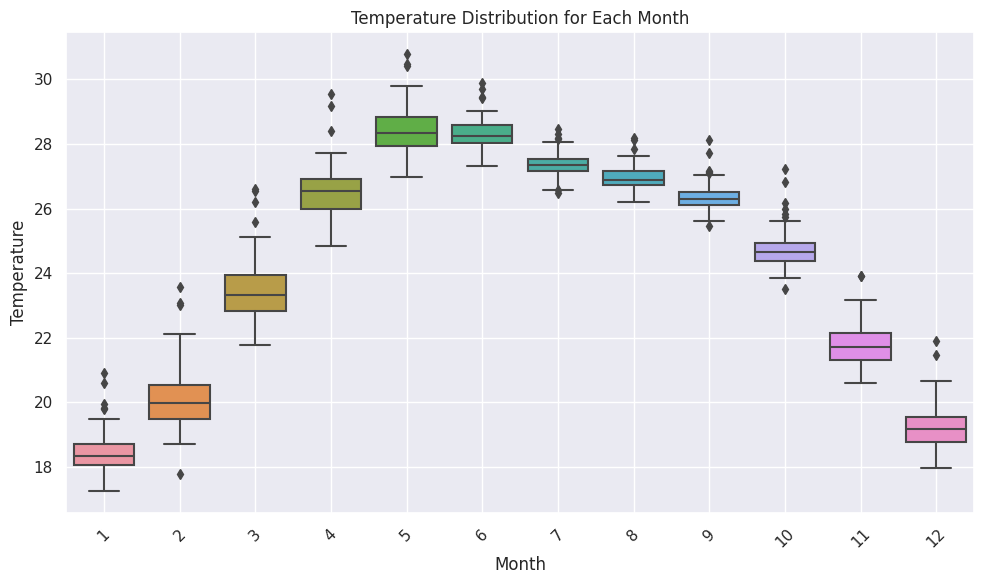

In [55]:
#ordering the month in sequential order
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
df_melt['Month'] = pd.Categorical(df_melt['Month'], categories=order, ordered=True)

# To check outliers and central tendency we create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melt, x='Month', y='Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature Distribution for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


We does not want to remove much of the outliers as they are mostly occured in recent year due to climate change. so removing them would affect our model from predicting future temperatures

#   Models Training and Tesing

In [81]:
melted_df.isnull().sum()

Year           0
Month          0
Temperature    0
Date           0
dtype: int64

In [91]:
#dropping ID and Year 
# cleaned_df = pd.get_dummies(cleaned_df)
# X = cleaned_df.drop(columns='Temperature')
# y = cleaned_df[['Temperature']]
df2 = melted_df[['Year', 'Month', 'Temperature']].copy()
df2 = pd.get_dummies(df2)
y = df2[['Temperature']]
X = df2.drop(columns='Temperature')

In [111]:
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

(1404, 13) (1404, 1)


# M1 : Linear Regression


In [128]:
#loading and training Linear Regression Model
m1 = LinearRegression()
m1.fit(X_train, y_train)
m1_y_pred = m1.predict(X_test)
m1_y_pred
print("Linear Regression: R2 Score:", r2_score(y_test, m1_y_pred))

Linear Regression: R2 Score: 0.9769066877965116


In [129]:
#Predicting 2018 Values
next_year = melted_df[melted_df['Year'] == 2017][['Year', 'Month']]
next_year.Year.replace(2017, 2018, inplace=True)
next_year = pd.get_dummies(next_year)
forecast_lr = m1.predict(next_year)

/tmp/ipykernel_33/3611415463.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  next_year.Year.replace(2017, 2018, inplace=True)


In [130]:
forecast_lr

array([[18.91264216],
       [20.56658921],
       [23.91495421],
       [26.96103042],
       [28.81963743],
       [28.7331456 ],
       [27.82973145],
       [27.42942407],
       [26.80465679],
       [25.20996776],
       [22.25279261],
       [19.59670872]])

In [131]:
# Transforming the linear regression predicted values to Dataframe
linear_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
linear_reg['Temperature'] = forecast_lr
linear_reg['Year'] = 2018
linear_reg


,ID,Month,Temperature,Year
0,0,1,18.912642,2018
1,1,2,20.566589,2018
2,2,3,23.914954,2018
3,3,4,26.961030,2018
4,4,5,28.819637,2018
5,5,6,28.733146,2018
6,6,7,27.829731,2018
7,7,8,27.429424,2018
8,8,9,26.804657,2018
9,9,10,25.209968,2018


# M2: Decision Tree Regressor


In [134]:
#loading and training Decision Tree
m2 = DecisionTreeRegressor()
m2.fit(X_train, y_train)
m2_pred = m2.predict(X_test)
m2_y_pred = m2.predict(X_test)
print("Decision Tree Regression: R2 Score:", r2_score(y_test, m2_y_pred))

Decision Tree Regression: R2 Score: 0.9631580588125299


In [143]:
#Predicting 2018 Values
forecast_dt = m2.predict(next_year)

In [144]:
# Transforming the Decision Tree regression predicted values to Dataframe
DT_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
DT_reg['Temperature'] = forecast_dt
DT_reg['Year'] = 2018
DT_reg

,ID,Month,Temperature,Year
0,0,1,20.59,2018
1,1,2,23.08,2018
2,2,3,25.58,2018
3,3,4,29.17,2018
4,4,5,30.41,2018
5,5,6,29.44,2018
6,6,7,28.18,2018
7,7,8,28.12,2018
8,8,9,28.11,2018
9,9,10,26.81,2018


# M3: XGboost Regressor

In [145]:
#loading and training XGboost Regressor
from xgboost import XGBRegressor
m3 = XGBRegressor()
m3.fit(X_train, y_train)
m3_y_pred = m3.predict(X_test)
print("Xgboost Regression: R2 Score:", r2_score(y_test, m3_y_pred))

Xgboost Regression: R2 Score: 0.974674750792047


In [151]:
#Predicting 2018 Values
forecast_xgb = m3.predict(next_year)

In [152]:
# Transforming the XGboost regressor predicted values to Dataframe
xgb_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
xgb_reg['Temperature'] = forecast_xgb
xgb_reg['Year'] = 2018
xgb_reg

,ID,Month,Temperature,Year
0,0,1,20.595449,2018
1,1,2,23.146658,2018
2,2,3,25.718908,2018
3,3,4,29.042833,2018
4,4,5,30.137783,2018
5,5,6,29.455978,2018
6,6,7,28.240349,2018
7,7,8,28.160662,2018
8,8,9,28.000391,2018
9,9,10,26.537817,2018


# M4: Gradient Boosting Regressor

In [150]:
#loading and training Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV

m4 = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
gs = GridSearchCV(m4, param_grid, cv=5, scoring='r2')
gs.fit(X_train, y_train)
m4 = gs.best_estimator_
m4.fit(X_train, y_train.values.ravel())
m4_y_pred = m4.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

In [156]:
#Predicting 2018 Values
forecast_gb = m4.predict(next_year)
print("Gradient boosting : R2 Score:", r2_score(y_test, m4_y_pred))

Gradient boosting : R2 Score: 0.9800030267541733


In [157]:
# Transforming the Gradient Boosting regression predicted values to Dataframe
GB_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
GB_reg['Temperature'] = forecast_gb
GB_reg['Year'] = 2018
GB_reg

,ID,Month,Temperature,Year
0,0,1,20.734934,2018
1,1,2,23.363330,2018
2,2,3,25.747771,2018
3,3,4,28.863408,2018
4,4,5,30.260042,2018
5,5,6,29.354281,2018
6,6,7,28.374431,2018
7,7,8,28.185302,2018
8,8,9,27.801733,2018
9,9,10,26.654607,2018


# Evaluating Model Performance

In [162]:
# converting values in dataframe to numpy
y_test = y_test.iloc[:, 0].to_numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [159]:
#flattening linear regression predicted values to match with y_test
m1_y_pred = m1_y_pred.flatten()
m2_y_pred = m2_y_pred.flatten()
m3_y_pred = m3_y_pred.flatten()
m4_y_pred = m4_y_pred.flatten()

print(y_test,"\n",m1_y_pred,"\n",m2_y_pred,"\n",m3_y_pred,"\n",m4_y_pred)

[28.51 19.03 19.23 28.32 18.96 21.99 21.23 28.64 18.15 21.13 25.58 28.79
 17.5  21.72 18.84 27.42 22.45 26.87 24.35 26.68 19.16 27.08 17.59 27.8
 26.91 19.81 27.5  18.4  20.54 26.31 22.46 24.32 28.08 20.   27.81 22.68
 23.13 26.8  22.87 23.53 18.79 26.97 27.55 23.43 25.63 19.02 28.29 28.25
 23.28 24.6  24.41 25.2  19.65 18.3  21.73 24.36 27.29 18.16 19.88 28.5
 26.86 18.07 29.46 28.31 24.35 24.42 23.84 20.28 25.55 23.52 24.7  24.24
 26.21 28.45 19.96 26.77 26.61 19.   28.82 26.26 18.4  27.46 28.13 17.79
 18.78 27.29 26.96 23.23 26.19 19.68 27.31 27.24 27.77 27.37 18.49 18.72
 26.23 25.47 21.32 18.88 17.8  28.16 24.42 26.26 21.15 21.14 28.04 28.27
 27.48 24.84 22.33 28.82 27.53 28.94 28.15 24.88 26.13 18.3  17.25 18.9
 27.54 24.73 22.81 19.41 25.96 21.8  18.63 22.64 21.71 20.86 26.36 27.66
 23.64 18.81 19.66 21.98 18.37 21.23 27.97 18.95 20.51 27.31 27.24 27.24
 18.15 26.25 26.82 28.47 25.68 28.38 24.12 26.28 27.66 23.52 27.78 26.88
 24.92 24.27 26.03 19.18 28.39 24.92 26.   28.11 25.67

In [160]:

def evaluate_model_performance(y_test, predicted_values, X_test):
    # Calculate MSE
    mse = mean_squared_error(y_test, predicted_values)
    print("MSE = MEAN SQUARED ERROR =", mse)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
    print("RMSE = ROOT MEAN SQUARED ERROR =", rmse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predicted_values)
    print("MAE = MEAN ABSOLUTE ERROR =", mae)

    # Calculate R^2 Score
    r2 = r2_score(y_test, predicted_values)
    print("r2 Score =", r2)
    
    # Calculate Adjusted R^2 Score
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    print('adjusted r2 score =', adjusted_r2)

    # Flatten y_test and predicted_values if needed
    if len(y_test.shape) > 1:
        y_test = y_test.flatten()
    if len(predicted_values.shape) > 1:
        predicted_values = predicted_values.flatten()

    # Calculate residuals
    residuals = y_test - predicted_values

    # Plotting residuals
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=predicted_values, y=residuals, color='red')
    plt.axhline(color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

----------------------Linear Regression Evaluation--------------------------
MSE = MEAN SQUARED ERROR = 0.30053227798856
RMSE = ROOT MEAN SQUARED ERROR = 0.548208243269435
MAE = MEAN ABSOLUTE ERROR = 0.40062225477758817
r2 Score = 0.9769066877965116
adjusted r2 score = 0.9761708714763024


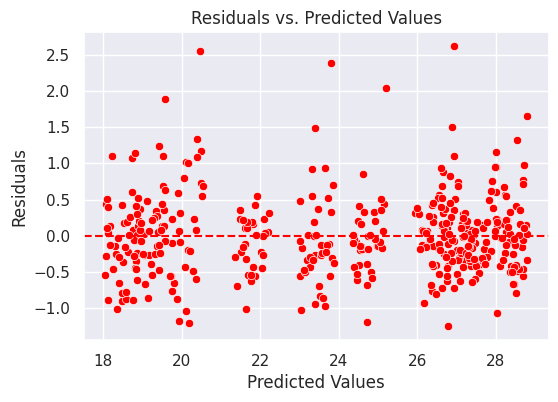




------------------Decision Tree Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.4794545023696682
RMSE = ROOT MEAN SQUARED ERROR = 0.6924265321098464
MAE = MEAN ABSOLUTE ERROR = 0.5233175355450236
r2 Score = 0.9631580588125299
adjusted r2 score = 0.9619841734315566


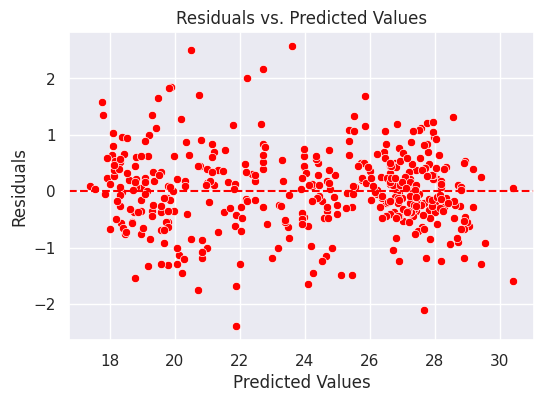




------------------XGboost Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.3295783111590363
RMSE = ROOT MEAN SQUARED ERROR = 0.5740891143011129
MAE = MEAN ABSOLUTE ERROR = 0.41148982585888905
r2 Score = 0.974674750792047
adjusted r2 score = 0.9738678188319897


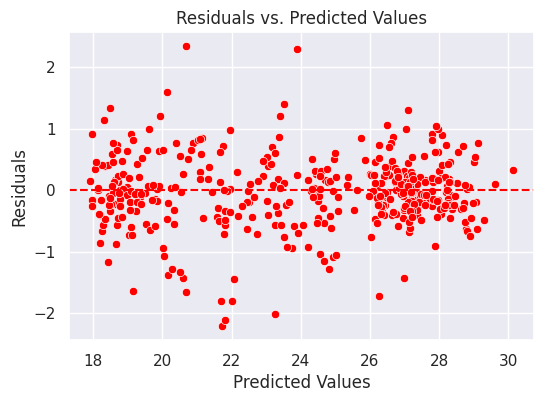




------------------Gradient Boosting Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.2602370707800319
RMSE = ROOT MEAN SQUARED ERROR = 0.5101343654176141
MAE = MEAN ABSOLUTE ERROR = 0.37672612869845096
r2 Score = 0.9800030267541733
adjusted r2 score = 0.9793658682929092


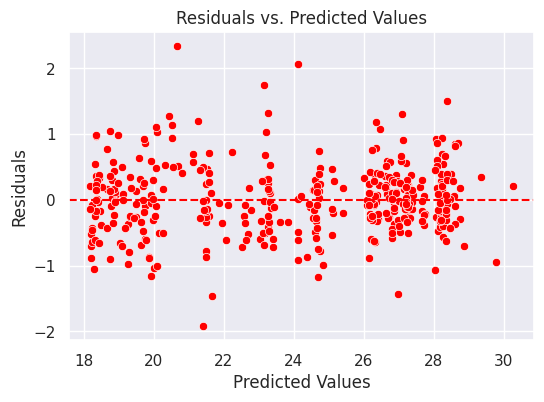

In [161]:
print("----------------------Linear Regression Evaluation--------------------------")
evaluate_model_performance( y_test, m1_y_pred, X_test)
print("\n\n\n------------------Decision Tree Regression Evaluation----------------------")
evaluate_model_performance( y_test, m2_y_pred, X_test)
print("\n\n\n------------------XGboost Regression Evaluation----------------------")
evaluate_model_performance( y_test, m3_y_pred, X_test)
print("\n\n\n------------------Gradient Boosting Regression Evaluation----------------------")
evaluate_model_performance( y_test, m4_y_pred, X_test)

This showcases both our Decision Tree Regressor and XGboost gives similar residual visualizations and they deviate too much from the actual values.

# **Submission**


### The above model evaluation clearly marks down Gradient boosting model performs accurately than all the other models.

### Submission File

In [163]:
GB_reg.to_csv('predictions.csv', index=False)

In [164]:
predictions_df = pd.read_csv('predictions.csv')
#Displaying the prediction Dataframe
print(predictions_df)

    ID  Month  Temperature  Year
0    0      1    20.734934  2018
1    1      2    23.363330  2018
2    2      3    25.747771  2018
3    3      4    28.863408  2018
4    4      5    30.260042  2018
5    5      6    29.354281  2018
6    6      7    28.374431  2018
7    7      8    28.185302  2018
8    8      9    27.801733  2018
9    9     10    26.654607  2018
10  10     11    23.915183  2018
11  11     12    22.073896  2018
